<a href="https://colab.research.google.com/github/SanikaNanavare/BTech_9F/blob/main/Low%20Light%20Image%20Enhacement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.model_selection import train_test_split
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to load full-resolution images
def load_lol_dataset(full_image_dir, enhanced_image_dir):
    """
    Load the LOL dataset with original resolutions.

    Args:
    - full_image_dir (str): Path to the low-light images folder.
    - enhanced_image_dir (str): Path to the ground truth images folder.

    Returns:
    - X (np.ndarray): Low-light images.
    - Y (np.ndarray): Enhanced (ground truth) images.
    """
    low_light_images = []
    enhanced_images = []

    for img_name in os.listdir(full_image_dir):
        # Construct paths for low-light and enhanced images
        low_light_path = os.path.join(full_image_dir, img_name)
        enhanced_path = os.path.join(enhanced_image_dir, img_name)

        # Load images
        low_light_img = cv2.imread(low_light_path)
        enhanced_img = cv2.imread(enhanced_path)

        # Check if both images are loaded successfully
        if low_light_img is None or enhanced_img is None:
            print(f"Skipping {img_name} due to loading issues.")
            continue

        # Ensure dimensions match
        if low_light_img.shape != enhanced_img.shape:
            print(f"Skipping {img_name} due to mismatched dimensions.")
            continue

        # Normalize images to [0, 1]
        low_light_img = low_light_img / 255.0
        enhanced_img = enhanced_img / 255.0

        low_light_images.append(low_light_img)
        enhanced_images.append(enhanced_img)

    return np.array(low_light_images), np.array(enhanced_images)

low_light_dir = "/content/drive/MyDrive/LOLdataset/our485/low/"
enhanced_dir = "/content/drive/MyDrive/LOLdataset/our485/high/" #Typo here 'T' to 't'

# Load and split dataset
X, Y = load_lol_dataset(low_light_dir, enhanced_dir)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

print(f"Dataset loaded: {len(X_train)} training samples, {len(X_val)} validation samples.")

Skipping enhanced_112.png due to loading issues.
Dataset loaded: 222 training samples, 25 validation samples.


In [ ]:
def data_generator(low_light_dir, enhanced_dir, batch_size, target_size=(256, 256)):
    """
    A generator to yield batches of low-light and enhanced images with matched file names.

    Args:
    - low_light_dir (str): Path to low-light images.
    - enhanced_dir (str): Path to enhanced (ground truth) images.
    - batch_size (int): Number of images per batch.
    - target_size (tuple): Target size to resize images.

    Yields:
    - Tuple (X_batch, Y_batch): Batch of low-light and enhanced images.
    """
    low_light_files = set(os.listdir(low_light_dir))
    enhanced_files = set(os.listdir(enhanced_dir))

    # Find common file names
    common_files = list(low_light_files.intersection(enhanced_files))
    common_files.sort()  # Ensure consistent ordering

    while True:  # Infinite loop for generator
        for i in range(0, len(common_files), batch_size):
            X_batch = []
            Y_batch = []
            batch_files = common_files[i:i + batch_size]

            for file_name in batch_files:
                # Construct paths
                low_img_path = os.path.join(low_light_dir, file_name)
                high_img_path = os.path.join(enhanced_dir, file_name)

                # Load images
                low_img = cv2.imread(low_img_path)
                high_img = cv2.imread(high_img_path)

                # Check if images are loaded successfully
                if low_img is None or high_img is None:
                    print(f"Skipping {file_name} due to loading issues.")
                    continue

                # Resize and normalize images
                low_img = cv2.resize(low_img, target_size) / 255.0
                high_img = cv2.resize(high_img, target_size) / 255.0

                X_batch.append(low_img)
                Y_batch.append(high_img)

            yield np.array(X_batch), np.array(Y_batch)

# Paths to dataset
low_light_dir = "/content/drive/MyDrive/LOLdataset/our485/low/"
enhanced_dir = "/content/drive/MyDrive/LOLdataset/our485/high/"

# Batch size and target size
batch_size = 4
target_size = (256, 256)

# Define data generators
train_gen = data_generator(low_light_dir, enhanced_dir, batch_size=batch_size, target_size=target_size)
val_gen = data_generator(low_light_dir, enhanced_dir, batch_size=batch_size, target_size=target_size)

In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
set_global_policy('mixed_float16')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simplified_llcnn():
    """
    Build a simplified LLCNN model to reduce memory usage.

    Returns:
    - model (tf.keras.Model): Simplified LLCNN model.
    """
    input_layer = layers.Input(shape=(None, None, 3))

    # Initial Convolutional Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)

    # Single Residual Block (simplified)
    skip = x
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, skip])  # Residual connection

    # Final Convolutional Layer
    output_layer = layers.Conv2D(3, (3, 3), activation='sigmoid', dtype='float32', padding='same')(x)

    # Create and return the model
    return models.Model(inputs=input_layer, outputs=output_layer)

# Instantiate the model
model = build_simplified_llcnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            896 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, None, None, 32) │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │            128 │ re_lu[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, None, None, 32) │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, None, None, 32) │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 3)  │            867 │ cast_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,267 (44.01 KB)

 Trainable params: 11,139 (43.51 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def combined_loss(y_true, y_pred):
    """
    Combines Mean Squared Error (MSE) and Structural Similarity Index (SSIM) loss.

    Args:
    - y_true: Ground truth images.
    - y_pred: Predicted images.

    Returns:
    - Combined loss value.
    """
    # MSE loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # SSIM loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Combine the losses
    return mse_loss + 0.5 * ssim_loss

In [ ]:
# Compile the model with the combined loss function and a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate
    loss=combined_loss
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

In [ ]:
# Train the model
batch_size = 10  # Further reduced batch size

history = model.fit(
    train_gen,
    steps_per_epoch=len(os.listdir(low_light_dir)) // batch_size,  # Steps per epoch
    validation_data=val_gen,
    validation_steps=len(os.listdir(low_light_dir)) // batch_size,  # Validation steps
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - loss: 0.4251 - val_loss: 0.2600
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.3646 - val_loss: 0.2971
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - loss: 0.2960 - val_loss: 0.3080
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.2858 - val_loss: 0.2474
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.2856 - val_loss: 0.3520
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - loss: 0.2319 - val_loss: 0.2463
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 0.2152 - val_loss: 0.2660
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.2228 - val_loss: 0.3157
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - loss: 0.1889 - val_loss: 0.2297
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 0.2005 - val_loss: 0.3156
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.1530 - val_loss: 0.2319
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/st

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Function to calculate PSNR and SSIM
def evaluate_metrics(Y_true, Y_pred):
    """
    Evaluate PSNR and SSIM metrics for the given ground truth and predicted images.

    Args:
    - Y_true (np.ndarray): Ground truth images.
    - Y_pred (np.ndarray): Predicted images.

    Returns:
    - average_psnr (float): Average PSNR over the dataset.
    - average_ssim (float): Average SSIM over the dataset.
    """
    psnr_values = []
    ssim_values = []

    for true_img, pred_img in zip(Y_true, Y_pred):
        # Ensure images are scaled back to [0, 255] for proper metric evaluation
        true_img = (true_img * 255).astype('uint8')
        pred_img = (pred_img * 255).astype('uint8')

        # PSNR calculation
        psnr = peak_signal_noise_ratio(true_img, pred_img, data_range=255)
        psnr_values.append(psnr)

        # SSIM calculation (explicitly setting win_size and channel_axis)
        ssim = structural_similarity(
            true_img,
            pred_img,
            data_range=255,
            channel_axis=2,  # Explicitly setting channel axis for multichannel images
            win_size=7       # Ensure window size is valid for small dimensions
        )
        ssim_values.append(ssim)

    average_psnr = sum(psnr_values) / len(psnr_values)
    average_ssim = sum(ssim_values) / len(ssim_values)

    return average_psnr, average_ssim


# Predict on validation data
Y_pred = model.predict(X_val)

# Ensure predictions are within [0, 1] range
Y_pred = np.clip(Y_pred, 0, 1)

# Evaluate metrics on validation set
average_psnr, average_ssim = evaluate_metrics(Y_val, Y_pred)

# Print results
print(f"Average PSNR: {average_psnr:.2f}")
print(f"Average SSIM: {average_ssim:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Average PSNR: 19.44
Average SSIM: 0.7602


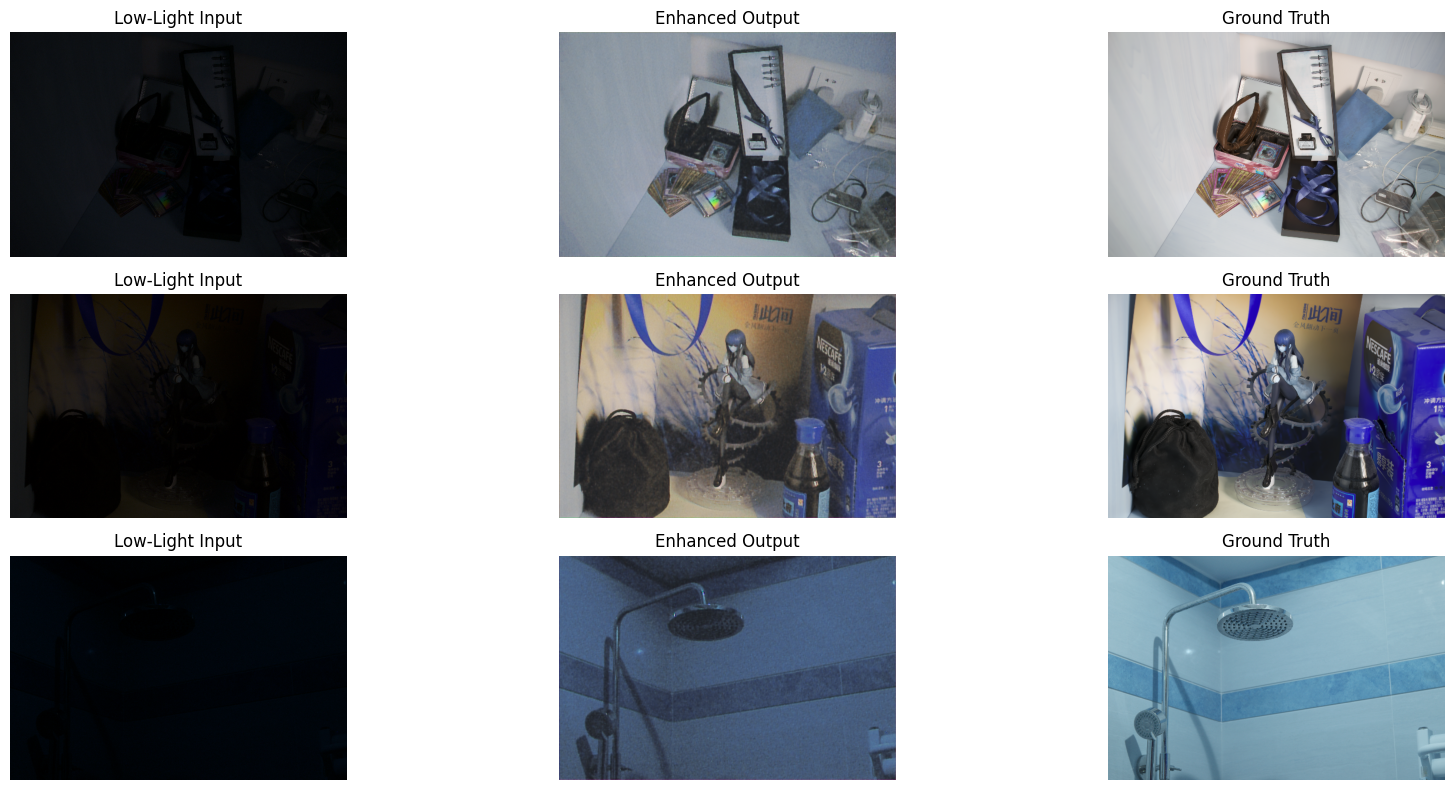

In [ ]:
import matplotlib.pyplot as plt

# Visualize low-light input, enhanced output, and ground truth
def visualize_results(low_light, enhanced, ground_truth, num_samples=3):
    plt.figure(figsize=(18, 8))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(low_light[i])
        plt.title("Low-Light Input")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(enhanced[i])
        plt.title("Enhanced Output")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(ground_truth[i])
        plt.title("Ground Truth")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(X_val, Y_pred, Y_val, num_samples=3)

**CHECK FOR SINGLE IMAGE**

PSNR: 30.75
SSIM: 0.9237


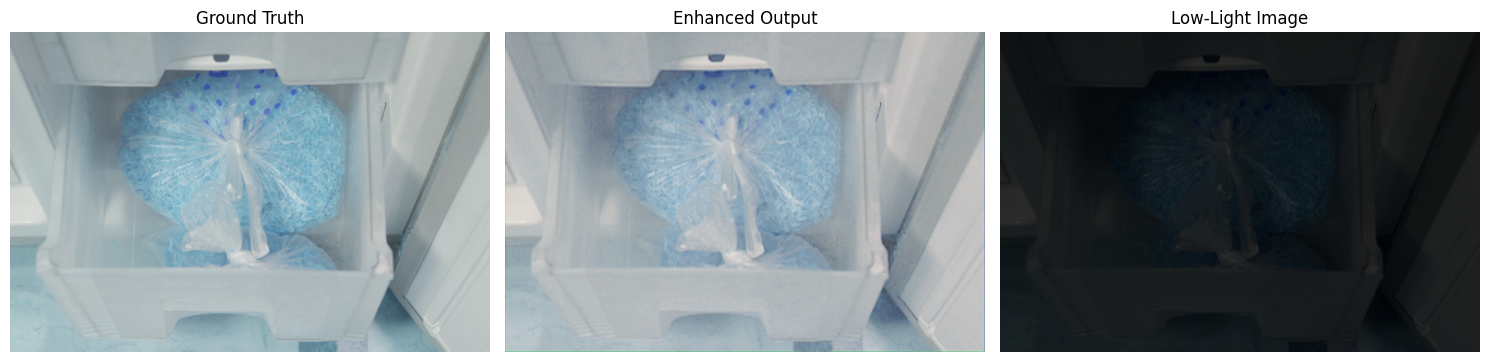

In [ ]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Function to calculate PSNR and SSIM for a single image
def evaluate_single_image_metrics(Y_true, Y_pred):
    """
    Evaluate PSNR and SSIM for the given ground truth and predicted image.

    Args:
    - Y_true (np.ndarray): Ground truth image.
    - Y_pred (np.ndarray): Predicted image.

    Returns:
    - psnr (float): PSNR value for the image.
    - ssim (float): SSIM value for the image.
    """
    # Ensure images are scaled back to [0, 255] for proper metric evaluation
    Y_true = (Y_true * 255).astype('uint8')
    Y_pred = (Y_pred * 255).astype('uint8')

    # PSNR calculation
    psnr = peak_signal_noise_ratio(Y_true, Y_pred, data_range=255)

    # SSIM calculation (explicitly setting win_size and channel_axis)
    ssim = structural_similarity(
        Y_true,
        Y_pred,
        data_range=255,
        channel_axis=2,  # Explicitly setting channel axis for multichannel images
        win_size=7       # Ensure window size is valid for small dimensions
    )

    return psnr, ssim

# Initialize variables to track the highest values
max_psnr = -np.inf
max_ssim = -np.inf
best_image_index = -1

# Iterate over the dataset to find the highest PSNR and SSIM
for i in range(len(Y_val)):
    true_img = Y_val[i]  # Ground truth image
    pred_img = Y_pred[i]  # Predicted image

    # Calculate metrics for the current image
    psnr_value, ssim_value = evaluate_single_image_metrics(true_img, pred_img)

    # Track the best image based on PSNR and SSIM
    if psnr_value > max_psnr and ssim_value > max_ssim:
        max_psnr = psnr_value
        max_ssim = ssim_value
        best_image_index = i

# Retrieve the best image
best_true_img = Y_val[best_image_index]
best_pred_img = Y_pred[best_image_index]

# Print the results for the image with highest PSNR and SSIM
print(f"PSNR: {max_psnr:.2f}")
print(f"SSIM: {max_ssim:.4f}")

# Visualize the best image pair (Ground Truth, Enhanced Output, and Low-Light Input)
plt.figure(figsize=(15, 5))

# Visualize Ground Truth
plt.subplot(1, 3, 1)
plt.imshow(best_true_img)
plt.title("Ground Truth")
plt.axis("off")

# Visualize Enhanced Output
plt.subplot(1, 3, 2)
plt.imshow(best_pred_img)
plt.title("Enhanced Output")
plt.axis("off")

# Visualize Low-Light Image (input image from X_val)
low_light_img = X_val[best_image_index]  # Assuming X_val contains the low-light images
plt.subplot(1, 3, 3)
plt.imshow(low_light_img)
plt.title("Low-Light Image")
plt.axis("off")

# Display the images
plt.tight_layout()
plt.show()
